# Solving Maxwell's equations in InSb to get mass of light

Taking data and algorithm from
Yu, Heffernan, and Talbayev [``Beyond the effective mass approximation: A predictive theory of the nonlinear optical response of conduction electrons''](https://doi.org/10.1103/PhysRevB.95.125201) Phys. Rev. B **95**, 125201 (2017)

In [1]:
from BeyoundEffMass import *
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simpson
from tqdm.notebook import tqdm

## Loading data for InSb

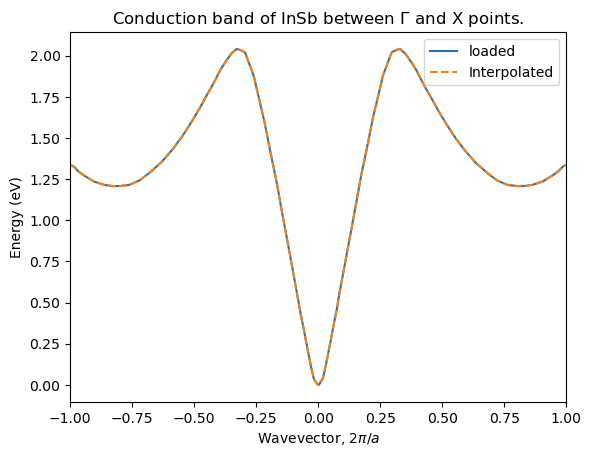

In [2]:
k, E_band = np.loadtxt("energy_xband_InSb.dat").T
# Interpolating

conduction_band = UnivariateSpline(k, E_band, s=0)
a = 0.64794e-9

plt.title(r"Conduction band of InSb between $\Gamma$ and X points.")
plt.plot(k / (2 * np.pi / a), E_band / e, label="loaded")
plt.xlabel(r"Wavevector, $2\pi/a$")
plt.ylabel("Energy (eV)")

plt.plot(k / (2 * np.pi / a), conduction_band(k) / e, "--", label="Interpolated")

plt.xlim(-1, 1)

plt.legend()
plt.show()

Initial pulse

In [3]:
E0 = 100e3 / 1e-2 # ******
f0 = 1e12
τd = 1e-12 #0.5e-12

def Ez_init(x):
    t = x / c
    return E0 * np.exp(-(t / τd) ** 2) * np.sin(2 * np.pi * f0 * t)

In [4]:
x, Δx1 = np.linspace(-25 * c * τd, 3 * c * τd, 2000, retstep=True)

Ez_init = Ez_init(x)

In [5]:
# Note that in the article Δx1 = 5e-6
Δx1

4.199194009004501e-06

In [6]:
# Sample length
d = 0.5e-3

Δx2 = 1.25e-6

Δt = 0.01 * min(Δx1, Δx2) / c

N2 = int(round(d / Δx2))

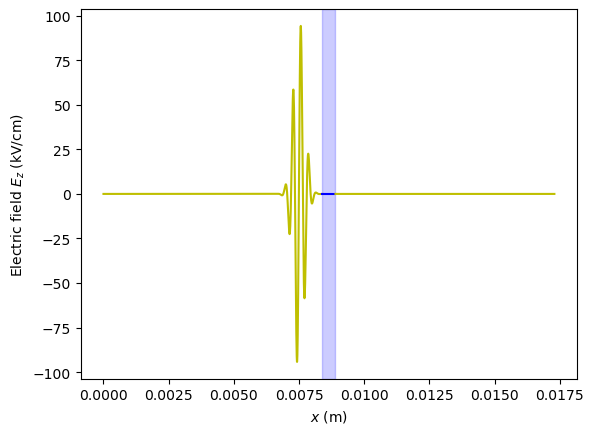

In [7]:
params = dict( 
    Δx1 = Δx1, 
    
    Δx2 = Δx2,
    N2 = N2,
    
    Ez_init = Ez_init, 
    
    diff_E = conduction_band.derivative(), 
    
    epsilon_infty = 15., #15.6,
    γ = 0.5e12,
    n = 7.3e13 / 1e-6,
)

sys = CBeyondEffMass(
    Δt = Δt, 
    **params
)

sys.plot_Ez()

In [8]:
def get_averages(Ez, Dz, Hy, x):
    """
    Calculate energy and momentum quantities for electromagnetic fields.
    
    Args:
        Ez: Electric field z-component
        Dz: Electric displacement z-component  
        Hy: Magnetic field y-component
        x: spatial grid array

    Returns:
        E: Total energy
        x_average: Energy-weighted average position
        g_M: Minkowski momentum
        g_A: Abraham momentum
    """
    
    # Calculate spatial step size for integration
    dx = x[1] - x[0]
    
    # Calculate energy density in matter (electric + magnetic contributions)
    u = 0.5 * (Ez * Dz + mu_0 * Hy ** 2)

    # Integrate energy density to get total energy
    E = simpson(u, dx = dx)

    # Calculate center of energy (energy-weighted average position)
    x_average = simpson(u * x, dx = dx) / E

    # Calculate Minkowski field momentum (D × H formulation)
    gM = -mu_0 * simpson(Dz * Hy, dx = dx)

    # Calculate Abraham field momentum (E × H / c² formulation)
    gA = -simpson(Ez * Hy, dx = dx) / c ** 2

    return E, x_average, gM, gA

In [9]:
values_region1 = []
values_region2 = []

  0%|          | 0/300000 [00:00<?, ?it/s]

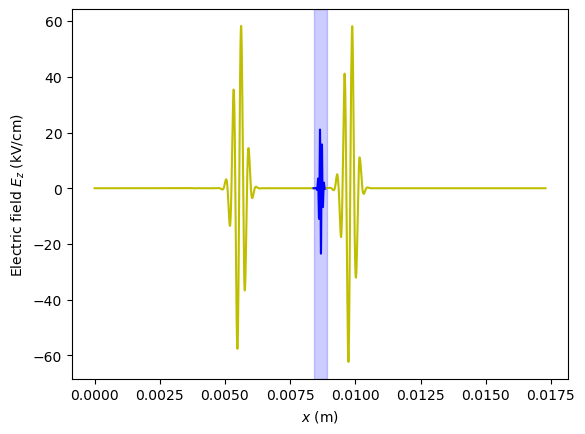

In [10]:
# propagation
n_steps = 300000
t = n_steps * Δt

for _ in tqdm(range(n_steps)):
    sys.single_step_propagation()

    values_region1.append(
        get_averages(sys.Ez1, epsilon_0 * sys.Ez1, sys.Hy1, sys.x1)
    )

    values_region2.append(
        get_averages(sys.Ez2, sys.Dz2, sys.Hy2, sys.x2)
    )

times = np.linspace(0, t, n_steps)

sys.plot_Ez()

In [11]:
E1, x_average1, gM1, gA1 = [np.array(_) for _ in zip(*values_region1)]
E2, x_average2, gM2, gA2 = [np.array(_) for _ in zip(*values_region2)]

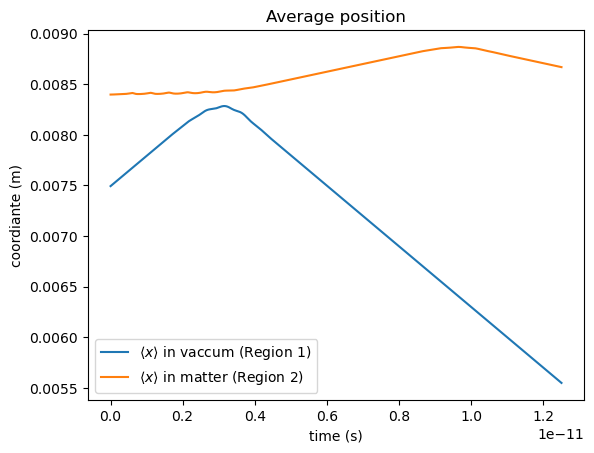

In [12]:
plt.title("Average position")
plt.plot(times, x_average1, label="$\\langle x \\rangle$ in vaccum (Region 1)")
plt.plot(times, x_average2, label="$\\langle x \\rangle$ in matter (Region 2)")
plt.xlabel("time (s)")
plt.ylabel("coordiante (m)")
plt.legend()
plt.show()

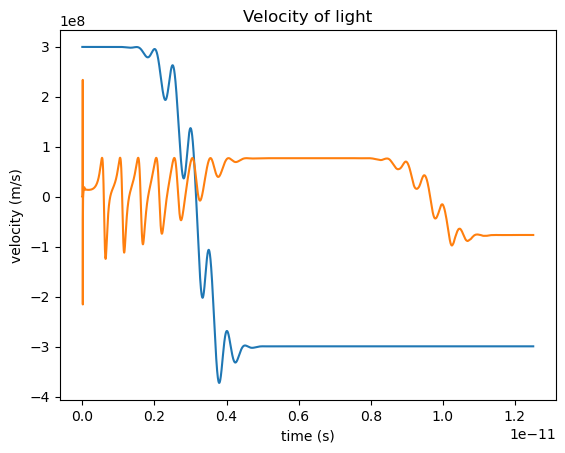

In [13]:
plt.title("Velocity of light")
v1 = np.gradient(x_average1, Δt)
v2 = np.gradient(x_average2, Δt)
plt.plot(times, v1)
plt.plot(times, v2)
plt.xlabel("time (s)")
plt.ylabel("velocity (m/s)")
plt.show()

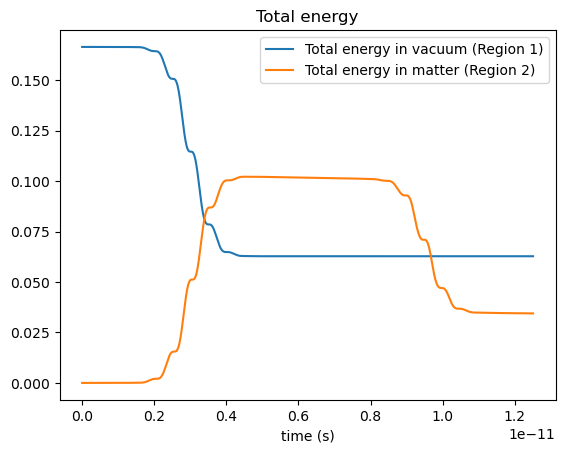

In [14]:
plt.title("Total energy")
plt.plot(times, E1, label="Total energy in vacuum (Region 1)") 
plt.plot(times, E2, label="Total energy in matter (Region 2)") 
plt.legend()
plt.xlabel("time (s)")
plt.show()

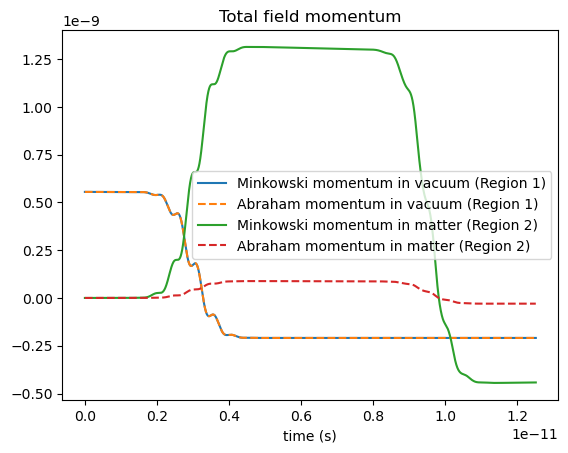

In [15]:
plt.title("Total field momentum")

plt.plot(times, gM1, label="Minkowski momentum in vacuum (Region 1)") 
plt.plot(times, gA1, '--', label="Abraham momentum in vacuum (Region 1)") 

plt.plot(times, gM2, label="Minkowski momentum in matter (Region 2)") 
plt.plot(times, gA2, '--', label="Abraham momentum in matter (Region 2)") 

plt.legend()
plt.xlabel("time (s)")
plt.show()

# Mass of light in vacuum

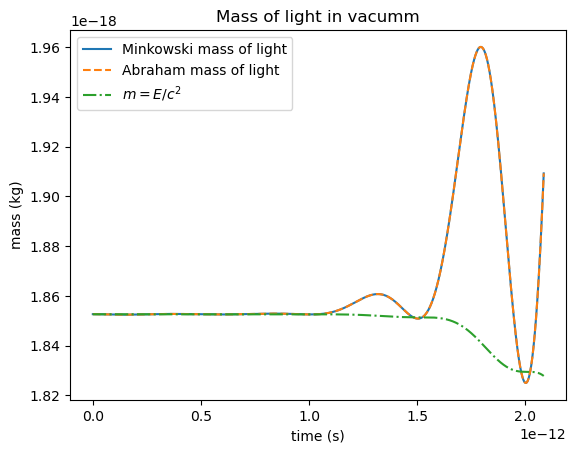

In [16]:
vacuum_indx = slice(0, 50000)


plt.title("Mass of light in vacumm")

plt.plot(times[vacuum_indx], gM1[vacuum_indx] / v1[vacuum_indx], label="Minkowski mass of light")
plt.plot(times[vacuum_indx], gA1[vacuum_indx] / v1[vacuum_indx], '--', label="Abraham mass of light")
plt.plot(times[vacuum_indx], E1[vacuum_indx] / c ** 2, '-.', label="$m = E/c^2$")

plt.legend()
plt.xlabel("time (s)")
plt.ylabel("mass (kg)")

plt.show()

# Mass of light in matter

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
/var/folders/xp/n2jfvg351jqb8pbr1p1tlccr0000gn/T/ipykernel_71237/3007980537.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(times[inside_matter], sys.epsilon_infty * E2[inside_matter] / c ** 2, '-.', label="$m = \epsilon_{\infty} E/c^2$")


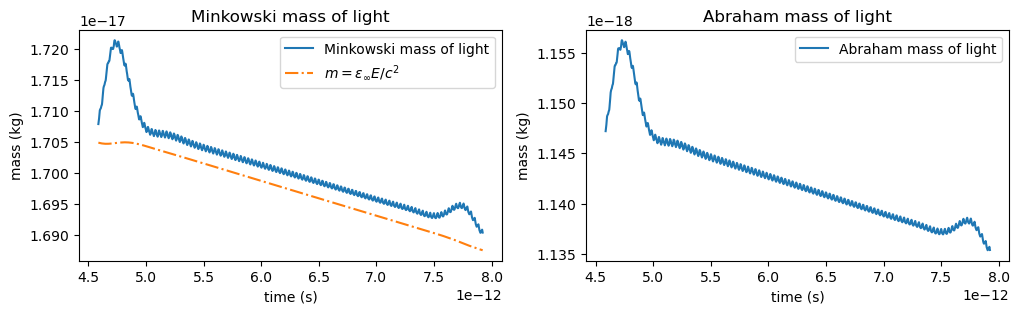

In [22]:
inside_matter = slice(110000, 190000)

plt.figure(figsize=(12,3))
plt.subplot(121)

plt.title("Minkowski mass of light")
plt.plot(times[inside_matter], gM2[inside_matter] / v2[inside_matter], label="Minkowski mass of light")
plt.plot(times[inside_matter], sys.epsilon_infty * E2[inside_matter] / c ** 2, '-.', label="$m = \epsilon_{\infty} E/c^2$")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("mass (kg)")


plt.subplot(122)
plt.title("Abraham mass of light")
plt.plot(times[inside_matter], gA2[inside_matter] / v2[inside_matter], label="Abraham mass of light")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("mass (kg)")

plt.show()